<a href="https://colab.research.google.com/github/jmarrietar/mineria-de-datos/blob/main/%5BProyecto%5D%20Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Proyecto Mineria de Datos - Clustering 

#### Aplicar mínimo tres algoritmos de agrupación y comparar los tres modelos con medidas internas y/o externas

# Data

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.cluster import hierarchy
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
import numpy as np
from scipy.cluster.hierarchy import fcluster
from sklearn import metrics
import plotly.express as px
import plotly.io as pio
import seaborn as sns; sns.set()
sns.set(rc={'figure.figsize':(9,8)})

In [ ]:
!gdown https://drive.google.com/uc?id=1_AJd_FiQ6LSWSK4e__ccfLzhu_sWWNUS

Downloading...
From: https://drive.google.com/uc?id=1_AJd_FiQ6LSWSK4e__ccfLzhu_sWWNUS
To: /content/OnlineRetail.csv
45.6MB [00:00, 212MB/s]


In [ ]:
online_retail = pd.read_csv(
    "OnlineRetail.csv",
    sep=",",
    dtype={"CustomerID": "object"},
    encoding="unicode_escape",
)

In [ ]:
def cluster_metrics(X, labels, metric="cosine"):
    """Calculate Silhoutte & Davies Bouldin score"""

    X2 = X.copy()
    X2["cluster"] = labels
    X2["silhouette_sample"] = metrics.silhouette_samples(X, labels, metric=metric)

    print(
        "Silhoutte score: {:.3f}".format(
            metrics.silhouette_score(X, labels, metric=metric)
        )
    )
    print("Intra Cluster Silhoutte score:")
    print(X2.groupby("cluster")["silhouette_sample"].mean())
    print(
        "Davies Bouldin score: {:.3f}".format(metrics.davies_bouldin_score(X, labels))
    )

# Pre-procesamiento

In [ ]:
# Create a new column for the total expenditure of that product in the purchase.
online_retail["total_sales_amount"] = (
    online_retail["UnitPrice"] * online_retail["Quantity"]
)

# Add column for cancelations 
online_retail['cancelation'] = online_retail['InvoiceNo'].apply(lambda x: x.startswith("C"))
online_retail['cancelation'] = online_retail['total_sales_amount'] <0

# Only positive purchases (No cancelations)
online_retail_purchases = online_retail[online_retail['cancelation'] == False] 

In [ ]:
customers_purchases = (
    online_retail_purchases.groupby(["CustomerID"])[["Quantity", "total_sales_amount"]]
    .agg("sum")
    .reset_index()
)

Se utilizaran para el clustering las columnas `Quantity` como la cantidad total de items el usuario ha comprado y `total_sales_amount` como la cantidad total gastada por ese usuario. 

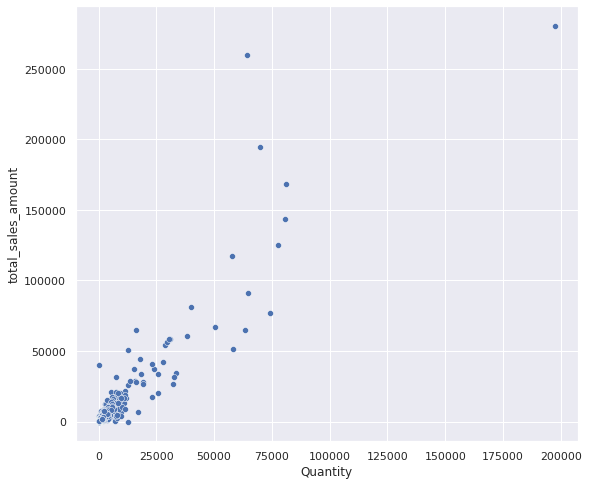

In [ ]:
sns.scatterplot(data=customers_purchases, x="Quantity", y="total_sales_amount")

Crear nuevas columnas con los diferentes formas de scalamiento 

In [ ]:
# Normalize
customers_purchases["Quantity_norm"] = preprocessing.normalize(customers_purchases["Quantity"].values.reshape(-1,1), norm='l2', axis=0)
customers_purchases["total_sales_amount_norm"] = preprocessing.normalize(customers_purchases["total_sales_amount"].values.reshape(-1,1), norm='l2', axis=0)

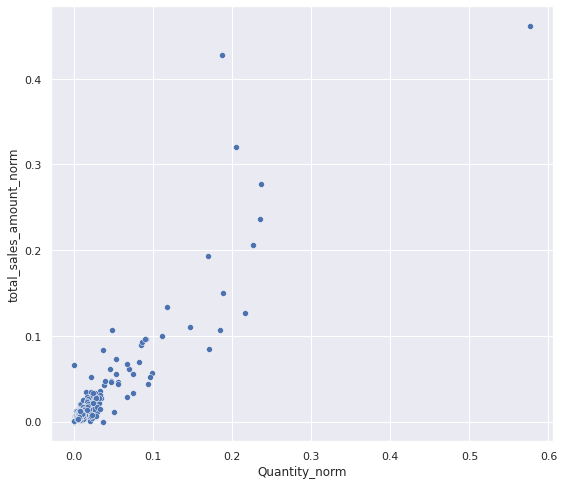

In [ ]:
sns.scatterplot(data=customers_purchases, x="Quantity_norm", y="total_sales_amount_norm")

# K-means

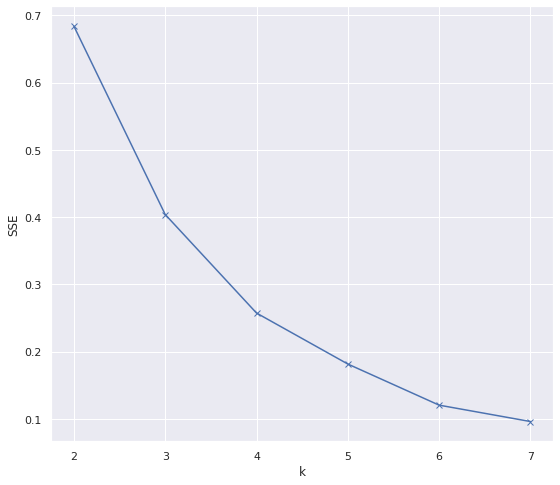

In [ ]:
Sum_of_squared_distances = []
K = range(2,8)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(customers_purchases[["Quantity_norm", "total_sales_amount_norm"]])
    Sum_of_squared_distances.append(km.inertia_)
    
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('SSE')
plt.show()

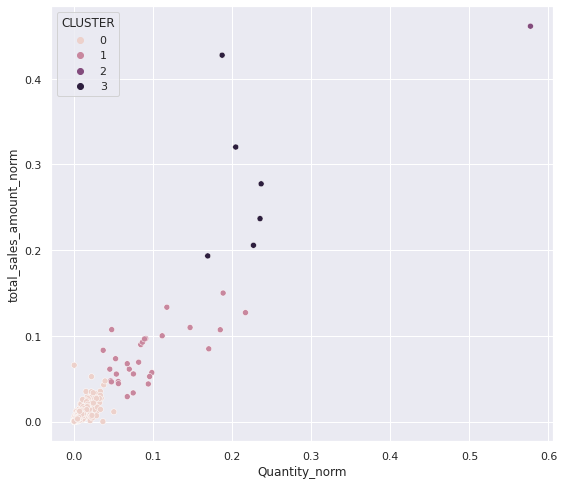

In [ ]:
# Create clusters
N_CLUSTERS = 4
kmeans = KMeans(n_clusters=N_CLUSTERS, random_state=0).fit(customers_purchases[["Quantity_norm", "total_sales_amount_norm"]])

# Assign cluster
customers_purchases['CLUSTER'] = kmeans.labels_

sns.scatterplot(data=customers_purchases, x="Quantity_norm", y="total_sales_amount_norm", hue="CLUSTER")

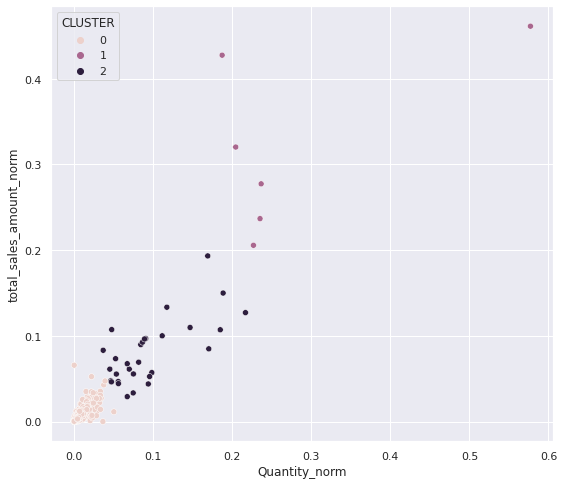

In [ ]:
# Create clusters
N_CLUSTERS = 3
kmeans = KMeans(n_clusters=N_CLUSTERS, random_state=0).fit(customers_purchases[["Quantity_norm", "total_sales_amount_norm"]])

# Assign cluster
customers_purchases['CLUSTER'] = kmeans.labels_

sns.scatterplot(data=customers_purchases, x="Quantity_norm", y="total_sales_amount_norm", hue="CLUSTER")

Medidas internas
- Distancia euclidiana (Internas) 
- Distancia coseno (Internas)
- Distancia Manhattan (Internas)
- Distancia Mahalanobis

In [ ]:
cluster_metrics(customers_purchases[["Quantity_norm", "total_sales_amount_norm"]], customers_purchases['CLUSTER'], metric="euclidean")

Silhoutte score: 0.957
Intra Cluster Silhoutte score:
cluster
0    0.962357
1    0.319567
2    0.351113
Name: silhouette_sample, dtype: float64
Davies Bouldin score: 0.566


# DBSCAN

In [ ]:
clustering = DBSCAN(eps=0.05, min_samples=2, metric="euclidean").fit(customers_purchases[["Quantity_norm", "total_sales_amount_norm"]])

# Assign cluster
customers_purchases['CLUSTER'] = clustering.labels_

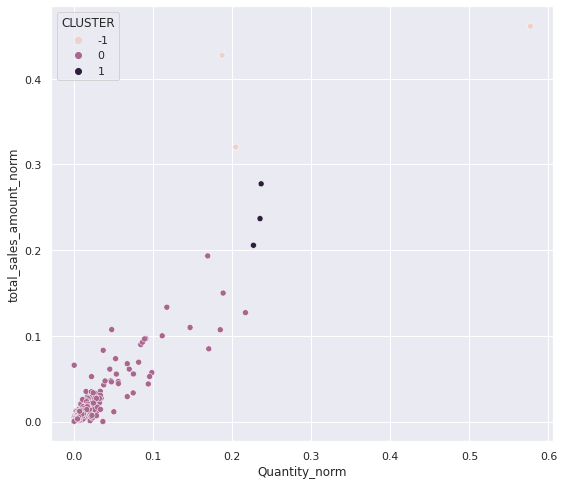

In [ ]:
sns.scatterplot(data=customers_purchases, x="Quantity_norm", y="total_sales_amount_norm", hue="CLUSTER")

In [ ]:
cluster_metrics(customers_purchases[["Quantity_norm", "total_sales_amount_norm"]], customers_purchases['CLUSTER'], metric="euclidean")

Silhoutte score: 0.979
Intra Cluster Silhoutte score:
cluster
-1   -0.282777
 0    0.979817
 1    0.785789
Name: silhouette_sample, dtype: float64
Davies Bouldin score: 0.859


# Jerarquico

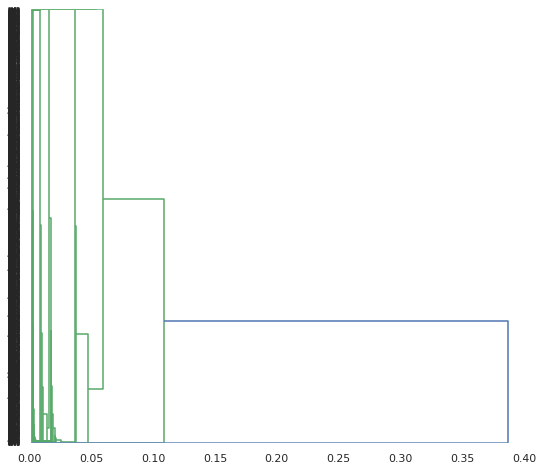

In [ ]:
Z = hierarchy.single(customers_purchases[["Quantity_norm", "total_sales_amount_norm"]])
dn = hierarchy.dendrogram(Z, orientation='right')

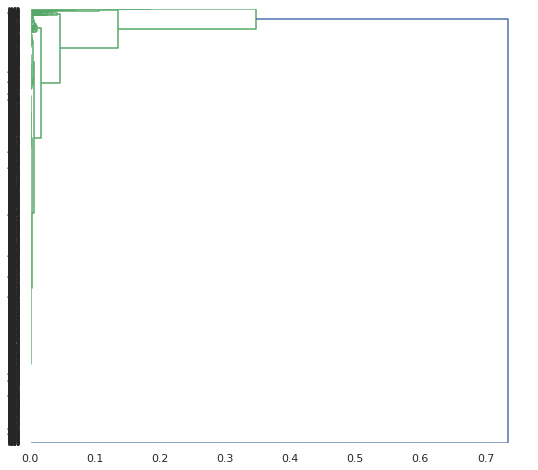

In [ ]:
Z = hierarchy.average(customers_purchases[["Quantity_norm", "total_sales_amount_norm"]])
dn = hierarchy.dendrogram(Z, orientation='right')

In [ ]:
max_d = 0.2
clusters = fcluster(Z, max_d, criterion='distance')
clusters

# Assign cluster
customers_purchases['CLUSTER'] = clusters

cluster_metrics(customers_purchases[["Quantity_norm", "total_sales_amount_norm"]], customers_purchases['CLUSTER'], metric="euclidean")

Silhoutte score: 0.981
Intra Cluster Silhoutte score:
cluster
1    0.981496
2    0.656036
3    0.000000
Name: silhouette_sample, dtype: float64
Davies Bouldin score: 0.209


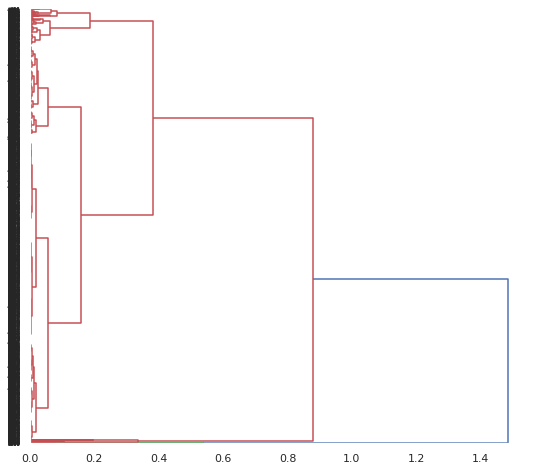

In [ ]:
Z = hierarchy.ward(customers_purchases[["Quantity_norm", "total_sales_amount_norm"]])
dn = hierarchy.dendrogram(Z, orientation='right')

In [ ]:
Z = hierarchy.complete(customers_purchases[["Quantity_norm", "total_sales_amount_norm"]])
dn = hierarchy.dendrogram(Z, orientation='right')